In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import cProfile
import time
import copy

import matplotlib.pyplot as plt

import ase.io

from utils.dataset import AtomisticDataset, create_dataloader
from utils.soap import PowerSpectrum
from utils.alchemical import AlchemicalCombine
from utils.linear import LinearModel
from utils.operations import SumStructures

torch.set_default_dtype(torch.float64)

In [3]:
n_test = 100
n_train = 100

frames = ase.io.read("data/xyz/data.xyz", f":{n_test + n_train}")

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = torch.tensor([frame.info["energy"] for frame in train_frames]).reshape(-1, 1)
test_energies = torch.tensor([frame.info["energy"] for frame in test_frames]).reshape(-1, 1)

train_forces = [torch.tensor(frame.arrays["forces"]) for frame in train_frames]
test_forces = [torch.tensor(frame.arrays["forces"]) for frame in test_frames]

print(f"using {n_train} training frames")

using 100 training frames


In [4]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": all_species,
# }

HYPERS_SMALL = {
    "cutoff": 5.0,
    "max_angular": 3,
    "max_radial": 4,
    "atomic_gaussian_width": 0.3,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"Gto": {}},
    "gradients": False,
}

# Optimization loop, energies only

In [5]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

In [6]:
train_dataset = AtomisticDataset(train_frames, all_species, HYPERS_SMALL, train_energies)
test_dataset = AtomisticDataset(test_frames, all_species, HYPERS_SMALL, test_energies)

In [16]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    device=device,
)

In [42]:
def loss_optimizer(predicted, actual, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    return loss

def loss_optimizer_forces(predicted, actual, predicted_f, actual_f, regularizer, weights):
    loss = torch.linalg.norm(predicted.flatten() - actual.flatten()) ** 2
    loss += torch.linalg.norm(predicted_f.flatten() - actual_f.flatten()) ** 2
    # regularize the loss, full dataset std
    loss += regularizer / torch.std(train_energies.flatten()) * torch.linalg.norm(weights) ** 2

    return loss

def loss_mae(predicted, actual):
    return torch.mean(torch.abs(predicted.flatten() - actual.flatten()))

def loss_rmse(predicted, actual):
    return torch.sqrt(torch.mean((predicted.flatten() - actual.flatten())**2))

In [9]:
class MixedSpeciesLinearModel(torch.nn.Module):
    def __init__(self, 
        species, 
        n_pseudo_species, 
        regularizer,
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.sum_structure = SumStructures()
        self.alchemical = AlchemicalCombine(species, n_pseudo_species)
        self.power_spectrum = PowerSpectrum()
        self.model = LinearModel(
            regularizer=regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )

        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, spherical_expansion, forward_forces=False):
        # TODO: remove gradients if forward_forces is false

        combined = self.alchemical(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)
        power_spectrum_per_structure = self.sum_structure(power_spectrum)
        energies, forces = self.model(power_spectrum_per_structure, with_forces=forward_forces)
        return energies, forces

    def initialize_model_weights(self, spherical_expansion, energies, forces=None):
        combined = self.alchemical(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)
        power_spectrum_per_structure = self.sum_structure(power_spectrum)
        self.model.initialize_model_weights(power_spectrum_per_structure, energies, forces)
        

In [10]:
N_PSEUDO_SPECIES = 4
TORCH_REGULARIZER = 1e-2
LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

mixed_species_model = MixedSpeciesLinearModel(
    species=all_species, 
    n_pseudo_species=N_PSEUDO_SPECIES, 
    regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True,
    random_initial_weights=True,
)

In [11]:
mixed_species_model.to(device=device)

# initialize the model
with torch.no_grad():
    for spherical_expansions, energies, _ in train_dataloader_no_batch:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        mixed_species_model.initialize_model_weights(spherical_expansions, energies)

if mixed_species_model.optimizable_weights:
    torch_loss_regularizer = TORCH_REGULARIZER
else:
    torch_loss_regularizer = 0
    # we can not use batches if we are training with linear algebra, we need to
    # have all training frames available
    assert train_dataloader.batch_size >= len(train_frames)

In [12]:
lr = 0.1
# optimizer = torch.optim.AdamW(
#     mixed_species_model.parameters(), 
#     lr=lr, weight_decay=0.0
# )

optimizer = torch.optim.LBFGS(
    mixed_species_model.parameters(), 
    lr=lr,
)

all_losses = []


filename = f"{mixed_species_model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if mixed_species_model.optimizable_weights:
    filename += "-opt-weights"

if mixed_species_model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [18]:
for epoch in range(5):
    epoch_start = time.time()

    # if UPDATE_SUPPORT_POINTS:
    #     # to update the support points, we need to have all training data at
    #     # once in memory
    #     for spherical_expansions, species, slices, _ in train_dataloader_no_batch:
    #         assert len(slices) == len(train_frames)
    #         # use `select_again=True` to re-select the same number of support
    #         # points. this might make convergence slower, but maybe able to
    #         # reach a lower final loss?
    #         #
    #         # with `select_again=False`, the environments selected in the first
    #         # fit above are used as support points
    #         mixed_species_model.update_support_points(
    #             spherical_expansions, species, slices, select_again=False
    #         )

    for spherical_expansions, energies, _ in train_dataloader:
        def single_step():
            optimizer.zero_grad()
           
            if not mixed_species_model.optimizable_weights:
                mixed_species_model.initialize_model_weights(spherical_expansions, energies)
                
            predicted, _ = mixed_species_model(spherical_expansions)

            loss = loss_optimizer(
                predicted, 
                energies, 
                torch_loss_regularizer, 
                mixed_species_model.model.weights
            )
            loss.backward(retain_graph=False)

            return loss
            
        loss = optimizer.step(single_step)
        all_losses.append(loss.item())

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            predicted = []
            reference = []
            for spherical_expansions, energies, _ in test_dataloader:
                reference.append(energies)
                predicted_e, _ = mixed_species_model(spherical_expansions)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            mae = loss_mae(predicted, reference)

            output.write(f"{n_epochs_total} {loss} {mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss.item():.4}, test mae={mae:.4}")
        
    n_epochs_total += 1

epoch 0 took 0.9261s, optimizer loss=2.211e+06, test mae=43.1
epoch 1 took 1.003s, optimizer loss=1.147e+05, test mae=19.82
epoch 2 took 1.023s, optimizer loss=2.194e+04, test mae=18.31
epoch 3 took 1.282s, optimizer loss=5.217e+03, test mae=17.71
epoch 4 took 1.028s, optimizer loss=2.503e+03, test mae=15.82


# Predicting forces with forward propagation

In [19]:
HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
HYPERS_GRAD["gradients"] = True

test_dataset_grad = AtomisticDataset(test_frames, all_species, HYPERS_GRAD, test_energies, test_forces)

test_dataloader_grad_no_batch = create_dataloader(
    test_dataset_grad,
    batch_size=len(test_dataset_grad),
    shuffle=False,
    device=device,
)

In [20]:
with torch.no_grad():
    for spherical_expansions, energies, forces in test_dataloader_grad_no_batch:
        predicted_e, predicted_f = mixed_species_model(spherical_expansions, forward_forces=True)

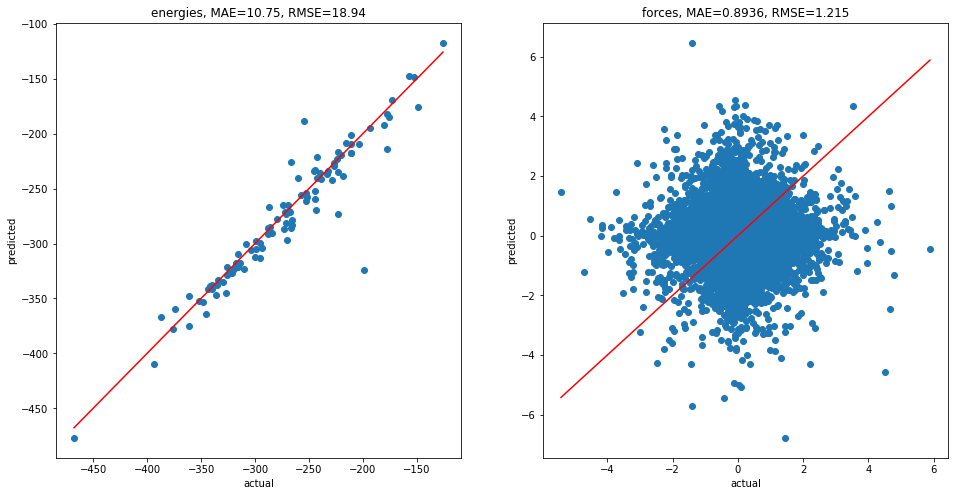

In [43]:
def parity_plots(energies, predicted_e, forces, predicted_f):
    predicted_e = predicted_e.detach()
    predicted_f = predicted_f.detach()

    fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

    mae = loss_mae(predicted_e, energies)
    rmse = loss_rmse(predicted_e, energies)
    ax_e.scatter(energies.cpu(), predicted_e.cpu())
    x = (torch.min(energies.flatten()).item(), torch.max(energies.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    mae = loss_mae(predicted_f, forces)
    rmse = loss_rmse(predicted_f, forces)
    ax_f.scatter(forces.cpu(), predicted_f.cpu())
    x = (torch.min(forces.flatten()).item(), torch.max(forces.flatten()).item())
    ax_f.plot(x, x, color="red")
    ax_f.set_title(f"forces, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_f.set_xlabel("actual")
    ax_f.set_ylabel("predicted")

    return fig

fig = parity_plots(energies, predicted_e, forces, predicted_f)

In [25]:
def check_finite_differences(model, frame, delta=1e-6):
    frame = frame.copy()
    delta_frame = frame.copy()
    delta_frame.positions[3, 1] += delta

    dataset = AtomisticDataset([frame, delta_frame], all_species, HYPERS_GRAD, torch.zeros(2, 1))
    dataloader = create_dataloader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        device=device,
    )

    for spherical_expansion, _, _ in dataloader:
        predicted_e, predicted_f = model(spherical_expansion, forward_forces=True)

    finite_diff = - (predicted_e[1] - predicted_e[0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", predicted_f[3, 1].item())

In [26]:
check_finite_differences(mixed_species_model, train_frames[22])

finite difference = 1.0766581226562266
computed gradient = 1.0766378965515344


## Training with forces, linear algebra

In [27]:
# new_mixed_species_model = MixedSpeciesLinearModel(
#     species=all_species, 
#     n_pseudo_species=N_PSEUDO_SPECIES, 
#     regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
#     optimizable_weights=False,
#     random_initial_weights=False, # <<<<==== VERY IMPORTANT
# )

# new_mixed_species_model.alchemical.combining_matrix = mixed_species_model.alchemical.combining_matrix

In [28]:
train_dataset_grad = AtomisticDataset(train_frames, all_species, HYPERS_GRAD, train_energies, train_forces)

train_dataloader_grad = create_dataloader(
    train_dataset_grad,
    batch_size=512,
    shuffle=True,
    device=device,
)

train_dataloader_grad_no_batch = create_dataloader(
    train_dataset_grad,
    batch_size=len(train_dataset_grad),
    shuffle=False,
    device=device,
)

In [29]:
# with cProfile.Profile() as profiler:
#     with torch.no_grad():
#         for spherical_expansions, energies, forces in train_dataloader_grad_no_batch:
#             new_mixed_species_model.initialize_model_weights(spherical_expansions, energies, forces)

In [30]:
# energies = None
# forces = None

# with torch.no_grad():
#     for spherical_expansions, energies, forces in test_dataloader_grad_no_batch:
#         predicted_e, predicted_f = new_mixed_species_model(spherical_expansions, forward_forces=True)

In [31]:
# fig = parity_plots(energies, predicted_e, forces, predicted_f)

# Optimization loop, energies and forces

In [33]:
for epoch in range(5):
    epoch_start = time.time()

    for spherical_expansions, energies, forces in train_dataloader_grad:
        def single_step():
            optimizer.zero_grad()
           
            if not mixed_species_model.optimizable_weights:
                mixed_species_model.initialize_model_weights(spherical_expansions, energies)
                
            predicted_e, predicted_f = mixed_species_model(spherical_expansions, forward_forces=True)

            loss = loss_optimizer_forces(
                predicted_e,
                energies,
                predicted_f,
                forces,
                torch_loss_regularizer,
                mixed_species_model.model.weights
            )
            loss.backward(retain_graph=False)

            return loss
            
        loss = optimizer.step(single_step)
        all_losses.append(loss.item())

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            predicted = []
            reference = []
            for spherical_expansions, energies, _ in test_dataloader:
                reference.append(energies)
                predicted_e, _ = mixed_species_model(spherical_expansions)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            mae = loss_mae(predicted, reference)

            output.write(f"{n_epochs_total} {loss} {mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss.item():.4}, test mae={mae:.4}")
        
    n_epochs_total += 1

epoch 5 took 42.27s, optimizer loss=1.087e+04, test mae=13.43
epoch 6 took 42.08s, optimizer loss=8.174e+03, test mae=12.92
epoch 7 took 42.32s, optimizer loss=6.473e+03, test mae=11.94
epoch 8 took 43.71s, optimizer loss=5.751e+03, test mae=10.92
epoch 9 took 42.98s, optimizer loss=5.162e+03, test mae=10.75


In [45]:
energies = None
forces = None

with torch.no_grad():
    for spherical_expansions, energies, forces in test_dataloader_grad_no_batch:
        predicted_e, predicted_f = mixed_species_model(spherical_expansions, forward_forces=True)

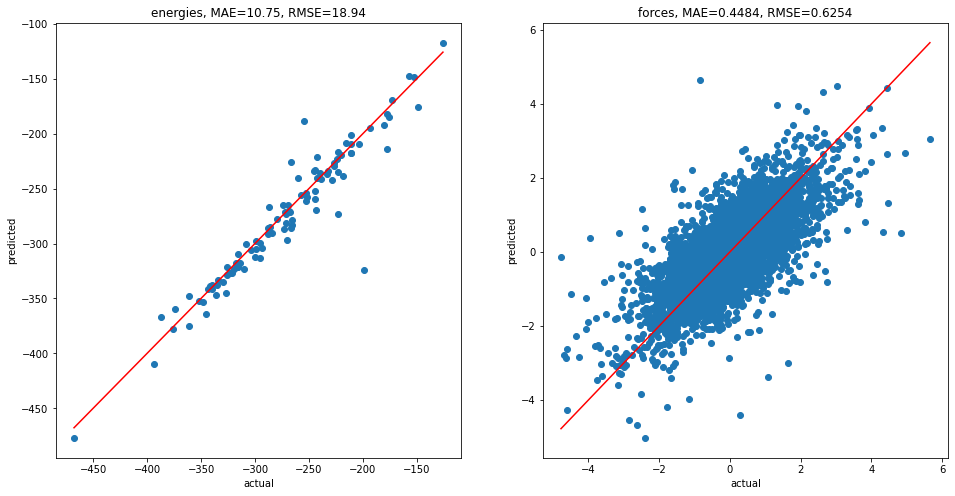

In [46]:
fig = parity_plots(energies, predicted_e, forces, predicted_f)

# TODO: predicting forces with backward propagation